<a href="https://colab.research.google.com/github/FYP-CodeByte/ckd-prediction-project/blob/master/models/CKD_Survival_Probability_(COX)_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from google.colab import drive

# For nicer plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

# Mount Google Drive
drive.mount('/content/drive')

# Define the base path for data access
base_path = '/content/drive/My Drive/CKD_Project/data/'

# Load the longitudinal dataset
print("Loading the longitudinal dataset...")
df_preprocessed = pd.read_csv(base_path + 'timeseries_final.csv')

# Convert Date column to datetime
df_preprocessed['Date'] = pd.to_datetime(df_preprocessed['Date'])

# Display basic information
print(f"Dataset shape: {df_preprocessed.shape}")
print(f"Number of patients: {df_preprocessed['Identifier'].nunique()}")
print(f"Number of progression events: {df_preprocessed['progression_event'].sum()}")
print(f"Sample of data:")
print(df_preprocessed.head())

# Check for missing values in key columns
missing_values = df_preprocessed[['Identifier', 'Date', 'CREATININE', 'eGFR_combined', 'progression_event']].isnull().sum()
print("\nMissing values in key columns:")
print(missing_values)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading the longitudinal dataset...
Dataset shape: (259, 60)
Number of patients: 83
Number of progression events: 21
Sample of data:
        Date  Identifier  CREATININE Gender   Age  eGFR VALUE  HBA1C  \
0 2020-09-29           1        0.90      M  69.0        84.0   7.40   
1 2020-09-30           1        1.03      M  69.0        72.0   8.70   
2 2020-09-30           1        0.94      M  70.0        79.0   8.70   
3 2020-06-23           2        1.38      M  53.0        54.0   6.88   
4 2020-07-12           2        1.43      M  53.0        52.0   6.90   

       SODIUM  POTASSIUM  CLORIDE  ...  prev_POTASSIUM  delta_POTASSIUM  \
0  137.000000   4.500000     99.0  ...             NaN              NaN   
1  138.000000   3.700000    101.0  ...        4.500000            -0.80   
2  138.000000   3.700000     97.0  ...        3.700000             0.00   
3  13

In [161]:
# Initialize an empty list to store the transformed data
cox_data = []

# For each patient, create appropriate intervals
print("Transforming longitudinal data to survival format...")
for patient_id, patient_df in df_preprocessed.sort_values(['Identifier', 'Date']).groupby('Identifier'):
    if len(patient_df) < 2:
        continue  # Skip patients with only one observation

    # Get patient data
    obs_times = patient_df['observation_time'].values

    # For each interval between observations
    for i in range(len(obs_times)-1):
        # Get start and end times of this interval
        start_time = obs_times[i]
        stop_time = obs_times[i+1]

        # Get covariate values at the start of the interval
        row_data = patient_df.iloc[i].to_dict()

        # Check if progression occurred in this interval
        # First try progression_event, then stage_change, then eGFR decline as fallback
        if 'progression_event' in patient_df.columns:
            event = int(patient_df.iloc[i+1]['progression_event']) if not pd.isna(patient_df.iloc[i+1]['progression_event']) else 0
        elif 'stage_change' in patient_df.columns and not pd.isna(patient_df.iloc[i+1]['stage_change']):
            event = int(patient_df.iloc[i+1]['stage_change'] > 0)
        else:
            # Use eGFR decline as proxy
            egfr_col = 'eGFR_combined' if 'eGFR_combined' in patient_df.columns else 'GFR'
            if egfr_col in patient_df.columns:
                egfr_current = patient_df.iloc[i][egfr_col]
                egfr_next = patient_df.iloc[i+1][egfr_col]
                if not pd.isna(egfr_current) and not pd.isna(egfr_next):
                    egfr_decline = egfr_current - egfr_next
                    event = int(egfr_decline > 5)  # Significant decline
                else:
                    event = 0
            else:
                event = 0

        # Create a record for this interval
        record = {
            'patient_id': patient_id,
            'start_time': start_time,
            'stop_time': stop_time,
            'event': event,
            # Lab values - using the correct column names from the dataset
            'creatinine': row_data['CREATININE'],
            'egfr': row_data['eGFR_combined'],
            'sodium': row_data['SODIUM'] if 'SODIUM' in row_data else None,
            'potassium': row_data['POTASSIUM'] if 'POTASSIUM' in row_data else None,
            'cloride': row_data['CLORIDE'] if 'CLORIDE' in row_data else None,
            'total_choles': row_data['TOTAL CHOLES'] if 'TOTAL CHOLES' in row_data else None,
            'urea': row_data['UREA'] if 'UREA' in row_data else None,
            'vitamin_d': row_data['VITAMIN D'] if 'VITAMIN D' in row_data else None,
            # Demographics
            'age': row_data['Age'],
            'gender': row_data['Gender']
        }

        # Add CKD stage if available
        if 'CKDStage' in patient_df.columns:
            record['ckd_stage'] = patient_df.iloc[i]['CKDStage']
        elif 'stage' in patient_df.columns:
            record['ckd_stage'] = patient_df.iloc[i]['stage']
        elif 'prev_stage' in patient_df.columns:
            record['ckd_stage'] = patient_df.iloc[i]['prev_stage']

        # Calculate changes from this time point to the next
        if i+1 < len(patient_df):
            next_row = patient_df.iloc[i+1]
            if 'CREATININE' in row_data and 'CREATININE' in next_row:
                record['creatinine_change'] = next_row['CREATININE'] - row_data['CREATININE']

            if 'POTASSIUM' in row_data and 'POTASSIUM' in next_row:
                record['potassium_change'] = next_row['POTASSIUM'] - row_data['POTASSIUM']

            if 'CLORIDE' in row_data and 'CLORIDE' in next_row:
                record['cloride_change'] = next_row['CLORIDE'] - row_data['CLORIDE']

        cox_data.append(record)

# Create the survival dataset
survival_df = pd.DataFrame(cox_data)

# Convert gender to numeric
survival_df['gender_numeric'] = (survival_df['gender'] == 'F').astype(int)

# Display basic information
print(f"Survival dataset shape: {survival_df.shape}")
print(f"Number of patients: {survival_df['patient_id'].nunique()}")
print(f"Number of progression events: {survival_df['event'].sum()}")
print(f"Event rate: {survival_df['event'].mean():.1%}")

# Verify that events were properly captured
if survival_df['event'].sum() == 0:
    print("WARNING: No progression events detected in transformed data!")

# Show columns in the dataset
print("\nColumns in survival dataset:")
print(list(survival_df.columns))

print("\nSample of transformed survival dataset:")
print(survival_df.head())

Transforming longitudinal data to survival format...
Survival dataset shape: (176, 19)
Number of patients: 57
Number of progression events: 21
Event rate: 11.9%

Columns in survival dataset:
['patient_id', 'start_time', 'stop_time', 'event', 'creatinine', 'egfr', 'sodium', 'potassium', 'cloride', 'total_choles', 'urea', 'vitamin_d', 'age', 'gender', 'ckd_stage', 'creatinine_change', 'potassium_change', 'cloride_change', 'gender_numeric']

Sample of transformed survival dataset:
   patient_id  start_time  stop_time  event  creatinine  egfr      sodium  \
0           1           0          1      0        0.90  84.0  137.000000   
1           1           1          1      0        1.03  72.0  138.000000   
2           2           0         19      0        1.38  54.0  136.996172   
3           2          19         59      0        1.43  52.0  138.196172   
4           2          59         86      0        1.46  51.0  136.996172   

   potassium  cloride  total_choles    urea  vitamin_d

In [163]:
# Create standardized features and necessary variables for Cox models
print("Preparing data for Cox modeling...")

# Create a working copy
cox_df = survival_df.copy()

# 1. Standardize numeric features (z-score normalization)
numeric_cols = ['creatinine', 'egfr', 'sodium', 'potassium',
                'cloride', 'total_choles']

if 'urea' in cox_df.columns:
    numeric_cols.append('urea')
if 'vitamin_d' in cox_df.columns:
    numeric_cols.append('vitamin_d')
if 'creatinine_change' in cox_df.columns:
    numeric_cols.append('creatinine_change')
if 'potassium_change' in cox_df.columns:
    numeric_cols.append('potassium_change')
if 'cloride_change' in cox_df.columns:
    numeric_cols.append('cloride_change')

# Standardize each numeric column
for col in numeric_cols:
    if col in cox_df.columns:
        mean_val = cox_df[col].mean()
        std_val = cox_df[col].std()
        # Avoid division by zero
        if std_val > 0:
            cox_df[f'{col}_scaled'] = (cox_df[col] - mean_val) / std_val
        else:
            cox_df[f'{col}_scaled'] = 0
            print(f"Warning: {col} has zero standard deviation")

# 2. Create categorical variables for directional changes
if 'creatinine_change' in cox_df.columns:
    cox_df['creatinine_increased'] = (cox_df['creatinine_change'] > 0).astype(int)
if 'potassium_change' in cox_df.columns:
    cox_df['potassium_increased'] = (cox_df['potassium_change'] > 0).astype(int)
if 'cloride_change' in cox_df.columns:
    cox_df['cloride_increased'] = (cox_df['cloride_change'] > 0).astype(int)

# 3. Create age groups for stratification
cox_df['age_group'] = pd.cut(
    cox_df['age'],
    bins=[0, 50, 65, 80, 100],
    labels=['<50', '50-65', '65-80', '80+']
).astype(str)

# Check age group distribution
print("\nAge group distribution:")
print(cox_df['age_group'].value_counts())

# 4. Create categories for potassium changes
if 'potassium_change' in cox_df.columns:
    cox_df['potassium_change_category'] = pd.cut(
        cox_df['potassium_change'],
        bins=[-float('inf'), -0.2, 0.2, float('inf')],
        labels=['decrease', 'stable', 'increase']
    )

    # Create dummy variables for potassium categories
    potassium_dummies = pd.get_dummies(cox_df['potassium_change_category'], prefix='potassium', drop_first=True)
    cox_df = pd.concat([cox_df, potassium_dummies], axis=1)

print("\nShape after preprocessing:", cox_df.shape)
print("Sample of prepared data:")
columns_to_show = ['patient_id', 'event', 'age_group']
if 'creatinine_scaled' in cox_df.columns:
    columns_to_show.append('creatinine_scaled')
if 'potassium_scaled' in cox_df.columns:
    columns_to_show.append('potassium_scaled')
if 'total_choles_scaled' in cox_df.columns:
    columns_to_show.append('total_choles_scaled')
if 'cloride_scaled' in cox_df.columns:
    columns_to_show.append('cloride_scaled')
if 'creatinine_increased' in cox_df.columns:
    columns_to_show.append('creatinine_increased')
if 'potassium_increased' in cox_df.columns:
    columns_to_show.append('potassium_increased')

print(cox_df[columns_to_show].head())

# Check if we still have events after preprocessing
print(f"\nEvents after preprocessing: {cox_df['event'].sum()}")

Preparing data for Cox modeling...

Age group distribution:
age_group
65-80    64
50-65    64
<50      29
80+      19
Name: count, dtype: int64

Shape after preprocessing: (176, 37)
Sample of prepared data:
   patient_id  event age_group  creatinine_scaled  potassium_scaled  \
0           1      0     65-80          -0.331101          0.664559   
1           1      0     65-80          -0.179708         -0.841690   
2           2      0     50-65           0.227890          0.551951   
3           2      0     50-65           0.286118          0.100076   
4           2      0     50-65           0.321055          0.551951   

   total_choles_scaled  cloride_scaled  creatinine_increased  \
0            -0.655498       -0.167341                     1   
1             3.122082        0.175125                     0   
2             0.013947       -0.167341                     1   
3             0.890600        0.209371                     1   
4             1.289079        0.003892        

Fitting Original Cox Proportional Hazards Model with ALL lab values...
Iteration 1: norm_delta = 5.34e-01, step_size = 0.9500, log_lik = -66.03068, newton_decrement = 3.85e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.47e-02, step_size = 0.9500, log_lik = -62.28159, newton_decrement = 1.16e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.38e-03, step_size = 0.9500, log_lik = -62.26995, newton_decrement = 3.67e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.61e-07, step_size = 1.0000, log_lik = -62.26991, newton_decrement = 1.08e-11, seconds_since_start = 0.0
Convergence success after 4 iterations.

Cox Proportional Hazards Model Results:
                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
creatinine_scaled   -0.114911   0.891445  0.063605       -0.239575   
sodium_scaled        0.064738   1.066880  0.078261       -0.088651   
potassium_scaled    -0.389162   0.677624

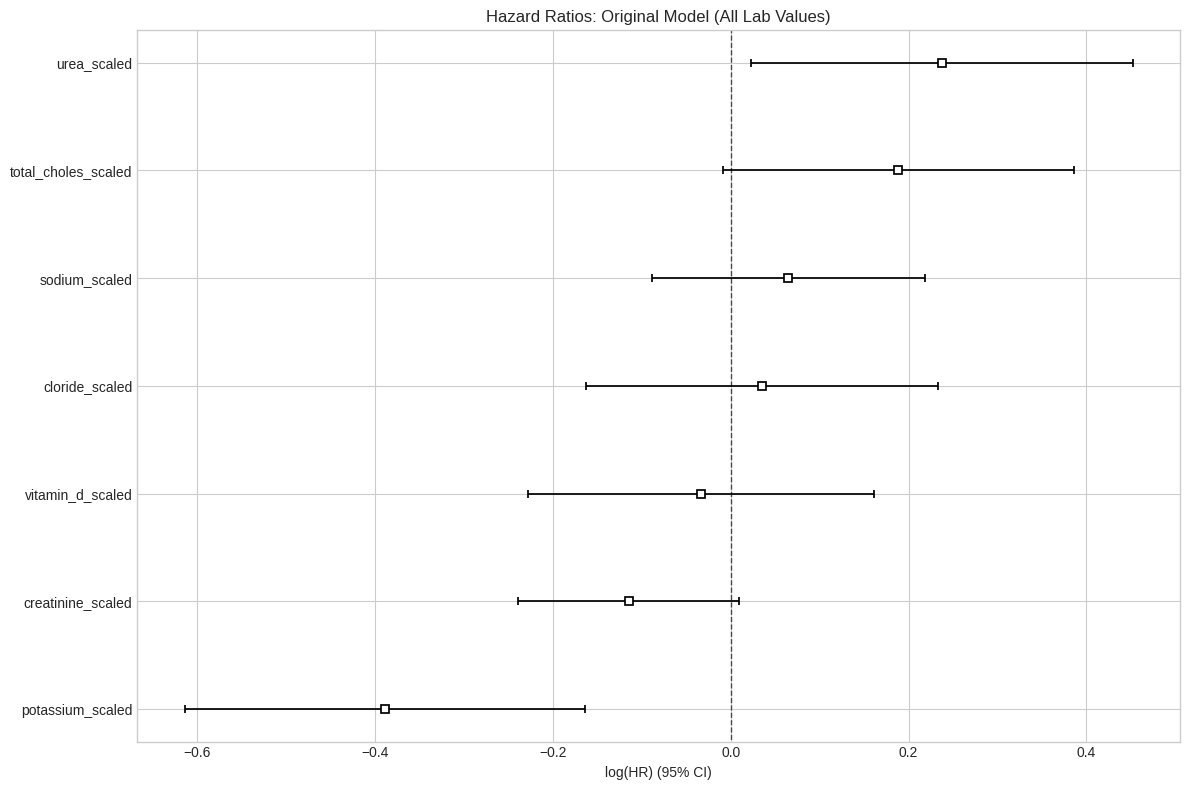

In [168]:
# Implement the original Cox model with ALL lab values
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

print("Fitting Original Cox Proportional Hazards Model with ALL lab values...")

try:
    # Use a small penalizer to stabilize estimation
    cph = CoxPHFitter(penalizer=0.1)

    # Create a comprehensive formula with all available lab values
    formula_parts = [
        "creatinine_scaled",
        "sodium_scaled",
        "potassium_scaled",
        "cloride_scaled",
        "total_choles_scaled"
    ]

    # Add optional lab values if they exist
    if 'vitamin_d_scaled' in cox_df.columns:
        formula_parts.append("vitamin_d_scaled")
    if 'urea_scaled' in cox_df.columns:
        formula_parts.append("urea_scaled")

    # Join all formula components
    formula = " + ".join(formula_parts)

    # Fit model with all lab values
    cph.fit(
        cox_df,
        duration_col='stop_time',
        event_col='event',
        formula=formula,
        strata=['age_group'],
        robust=True,  # Use robust standard errors
        show_progress=True
    )

    # Display model summary
    print("\nCox Proportional Hazards Model Results:")
    print(cph.summary)

    # Check the log-likelihood and AIC of the model
    print(f"\nLog-likelihood: {cph.log_likelihood_:.4f}")
    print(f"AIC: {cph.AIC_partial_:.4f}")

    # Calculate concordance index (C-index)
    pred_hazard = cph.predict_partial_hazard(cox_df)
    c_index = concordance_index(cox_df['stop_time'], -pred_hazard, cox_df['event'])
    print(f"Concordance Index (C-index): {c_index:.4f}")

    # Plot hazard ratios with confidence intervals
    plt.figure(figsize=(12, 8))
    cph.plot()
    plt.title('Hazard Ratios: Original Model (All Lab Values)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting Cox model: {e}")

Fitting Change-Based Cox Proportional Hazards Model with ALL lab values...
Iteration 1: norm_delta = 7.83e-01, step_size = 0.9500, log_lik = -66.03068, newton_decrement = 1.04e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.19e-01, step_size = 0.9500, log_lik = -59.22946, newton_decrement = 1.73e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.42e-02, step_size = 0.9500, log_lik = -57.53602, newton_decrement = 4.43e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.28e-05, step_size = 1.0000, log_lik = -57.53157, newton_decrement = 1.69e-07, seconds_since_start = 0.0
Iteration 5: norm_delta = 3.72e-09, step_size = 1.0000, log_lik = -57.53157, newton_decrement = 4.27e-16, seconds_since_start = 0.0
Convergence success after 5 iterations.

Change-Based Cox Model Results (All Lab Values):
                              coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                 
creatinine_change_scaled 

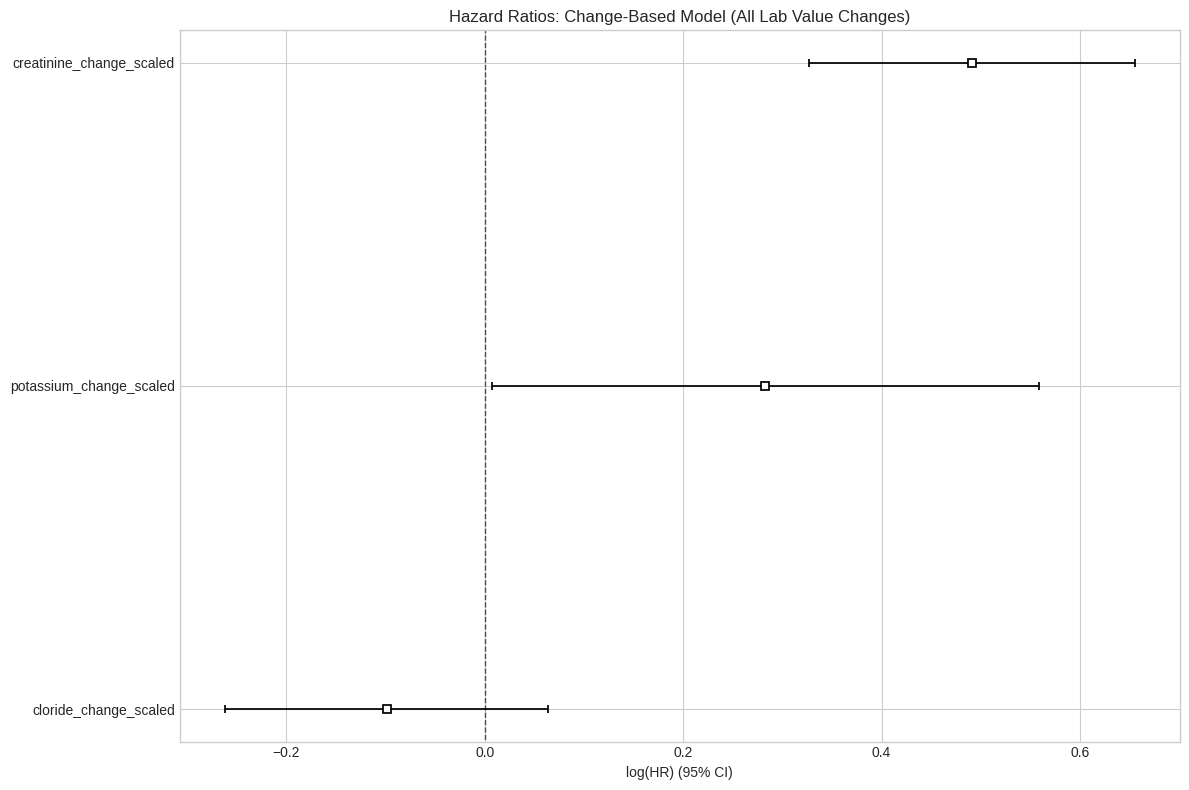

In [171]:
# Implement the change-based Cox model with ALL lab value changes
print("Fitting Change-Based Cox Proportional Hazards Model with ALL lab values...")

try:
    # Use a small penalizer to stabilize estimation
    cph_change = CoxPHFitter(penalizer=0.1)

    # Create formula focusing on changes in ALL lab values
    change_formula_parts = []

    # Add all available change variables
    if 'creatinine_change_scaled' in cox_df.columns:
        change_formula_parts.append("creatinine_change_scaled")
    if 'sodium_change_scaled' in cox_df.columns:
        change_formula_parts.append("sodium_change_scaled")
    if 'potassium_change_scaled' in cox_df.columns:
        change_formula_parts.append("potassium_change_scaled")
    if 'cloride_change_scaled' in cox_df.columns:
        change_formula_parts.append("cloride_change_scaled")
    if 'total_choles_change_scaled' in cox_df.columns:
        change_formula_parts.append("total_choles_change_scaled")
    if 'vitamin_d_change_scaled' in cox_df.columns:
        change_formula_parts.append("vitamin_d_change_scaled")
    if 'urea_change_scaled' in cox_df.columns:
        change_formula_parts.append("urea_change_scaled")

    # Combine formula parts
    change_formula = " + ".join(change_formula_parts)

    # Fit model with changes in lab values
    cph_change.fit(
        cox_df,
        duration_col='stop_time',
        event_col='event',
        formula=change_formula,
        strata=['age_group'],
        robust=True,
        show_progress=True
    )

    # Display model summary
    print("\nChange-Based Cox Model Results (All Lab Values):")
    print(cph_change.summary)

    # Check the log-likelihood and AIC of the model
    print(f"\nLog-likelihood: {cph_change.log_likelihood_:.4f}")
    print(f"AIC: {cph_change.AIC_partial_:.4f}")

    # Calculate concordance index (C-index)
    pred_hazard = cph_change.predict_partial_hazard(cox_df)
    c_index = concordance_index(cox_df['stop_time'], -pred_hazard, cox_df['event'])
    print(f"Concordance Index (C-index): {c_index:.4f}")

    # Plot hazard ratios with confidence intervals
    plt.figure(figsize=(12, 8))
    cph_change.plot()
    plt.title('Hazard Ratios: Change-Based Model (All Lab Value Changes)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting Change-Based Cox model: {e}")
    print(f"Formula attempted: {change_formula}")

Fitting Directional Cox Proportional Hazards Model with ALL lab values...
Iteration 1: norm_delta = 6.10e-01, step_size = 0.9500, log_lik = -66.03068, newton_decrement = 7.49e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.22e-02, step_size = 0.9500, log_lik = -58.42497, newton_decrement = 7.03e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.99e-03, step_size = 0.9500, log_lik = -58.35435, newton_decrement = 2.81e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.69e-06, step_size = 1.0000, log_lik = -58.35406, newton_decrement = 2.38e-10, seconds_since_start = 0.0
Convergence success after 4 iterations.

Directional Cox Model Results (All Lab Values):
                          coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                             
creatinine_increased  1.191529   3.292112  0.142601        0.912037   
potassium_increased   0.283507   1.327778  0.202617       -0.113616   
cloride_increased    -0.3

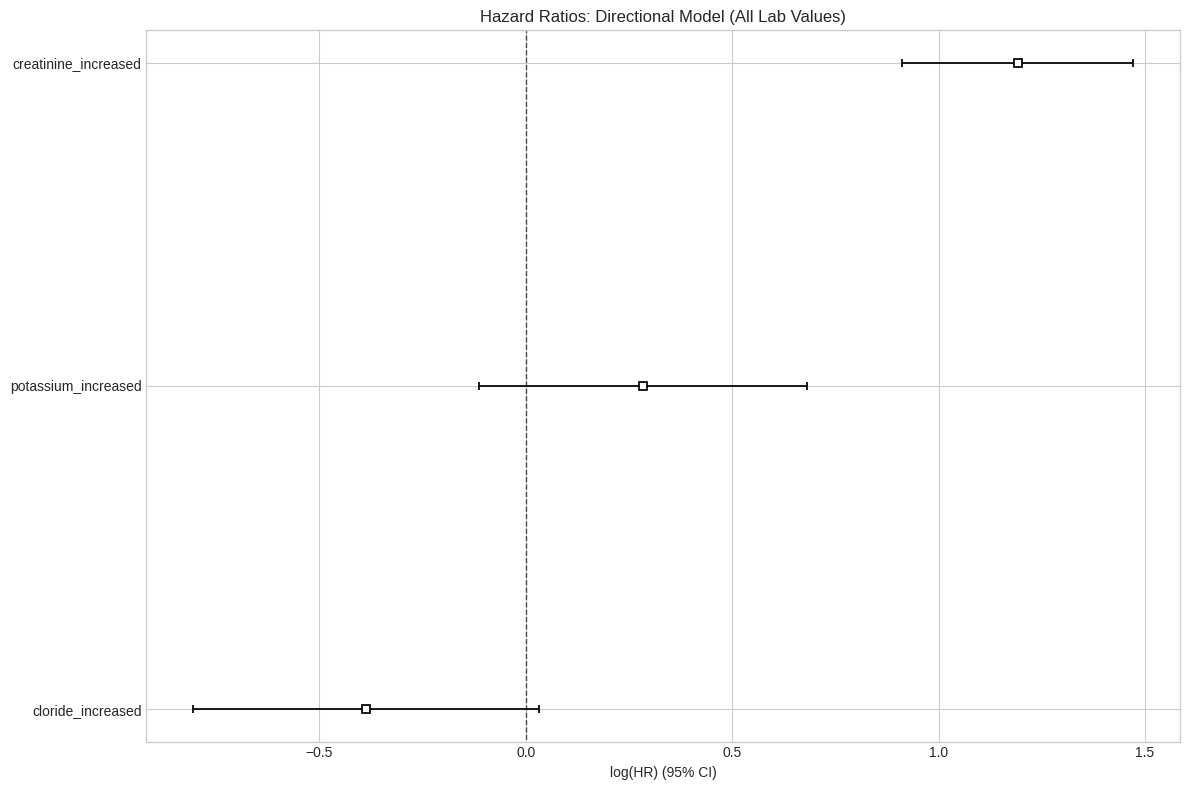

In [169]:
# Implement the directional Cox model with ALL lab values
print("Fitting Directional Cox Proportional Hazards Model with ALL lab values...")

try:
    # Use a small penalizer to stabilize estimation
    cph_directional = CoxPHFitter(penalizer=0.1)

    # Create formula using ALL directional indicators
    directional_formula_parts = []

    # Add all directional variables
    if 'creatinine_increased' in cox_df.columns:
        directional_formula_parts.append("creatinine_increased")
    if 'sodium_increased' in cox_df.columns:
        directional_formula_parts.append("sodium_increased")
    if 'potassium_increased' in cox_df.columns:
        directional_formula_parts.append("potassium_increased")
    if 'cloride_increased' in cox_df.columns:
        directional_formula_parts.append("cloride_increased")
    if 'total_choles_increased' in cox_df.columns:
        directional_formula_parts.append("total_choles_increased")
    if 'vitamin_d_increased' in cox_df.columns:
        directional_formula_parts.append("vitamin_d_increased")
    if 'urea_increased' in cox_df.columns:
        directional_formula_parts.append("urea_increased")

    # Add any missing directional indicators that we need to create
    for lab in ['sodium', 'total_choles', 'vitamin_d', 'urea']:
        change_col = f'{lab}_change'
        increased_col = f'{lab}_increased'

        # Create the directional indicator if we have the change but not the indicator
        if change_col in cox_df.columns and increased_col not in cox_df.columns:
            cox_df[increased_col] = (cox_df[change_col] > 0).astype(int)
            directional_formula_parts.append(increased_col)

    # Combine formula parts
    directional_formula = " + ".join(directional_formula_parts)

    # Fit model with directional changes
    cph_directional.fit(
        cox_df,
        duration_col='stop_time',
        event_col='event',
        formula=directional_formula,
        strata=['age_group'],
        robust=True,
        show_progress=True
    )

    # Display model summary
    print("\nDirectional Cox Model Results (All Lab Values):")
    print(cph_directional.summary)

    # Check the log-likelihood and AIC of the model
    print(f"\nLog-likelihood: {cph_directional.log_likelihood_:.4f}")
    print(f"AIC: {cph_directional.AIC_partial_:.4f}")

    # Calculate concordance index (C-index)
    pred_hazard = cph_directional.predict_partial_hazard(cox_df)
    c_index = concordance_index(cox_df['stop_time'], -pred_hazard, cox_df['event'])
    print(f"Concordance Index (C-index): {c_index:.4f}")

    # Plot hazard ratios with confidence intervals
    plt.figure(figsize=(12, 8))
    cph_directional.plot()
    plt.title('Hazard Ratios: Directional Model (All Lab Values)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting Directional Cox model: {e}")
    print(f"Formula attempted: {directional_formula}")

In [170]:
# First create categorical variables for all lab changes
print("Creating categorical variables for all lab changes...")

# Define the function to categorize changes
def categorize_change(change_col, bin_edges=[-float('inf'), -0.2, 0.2, float('inf')],
                     labels=['decrease', 'stable', 'increase']):
    if change_col in cox_df.columns:
        cat_col = f"{change_col.replace('_change', '')}_change_category"
        cox_df[cat_col] = pd.cut(
            cox_df[change_col],
            bins=bin_edges,
            labels=labels
        )
        # Create dummy variables for each category
        dummies = pd.get_dummies(cox_df[cat_col], prefix=cat_col.replace('_change_category', ''), drop_first=True)
        return cox_df, dummies
    return cox_df, None

# Process all available lab changes
all_dummies = []
for lab in ['creatinine', 'sodium', 'potassium', 'cloride', 'total_choles', 'vitamin_d', 'urea']:
    change_col = f'{lab}_change'
    cox_df, dummies = categorize_change(change_col)
    if dummies is not None:
        all_dummies.append(dummies)

# Concatenate all dummies
if all_dummies:
    cox_df = pd.concat([cox_df] + all_dummies, axis=1)

# Implement the categorical Cox model
print("Fitting Categorical Cox Proportional Hazards Model with ALL lab values...")

try:
    # Use a small penalizer to stabilize estimation
    cph_categorical = CoxPHFitter(penalizer=0.1)

    # Create formula with categorical indicators for all available labs
    categorical_formula_parts = []

    # Check for each possible categorical dummy
    for lab in ['creatinine', 'sodium', 'potassium', 'cloride', 'total_choles', 'vitamin_d', 'urea']:
        stable_col = f'{lab}_stable'
        increase_col = f'{lab}_increase'

        if stable_col in cox_df.columns:
            categorical_formula_parts.append(stable_col)
        if increase_col in cox_df.columns:
            categorical_formula_parts.append(increase_col)

    # Combine formula parts
    categorical_formula = " + ".join(categorical_formula_parts)

    # Fit the model
    cph_categorical.fit(
        cox_df,
        duration_col='stop_time',
        event_col='event',
        formula=categorical_formula,
        strata=['age_group'],
        robust=True,
        show_progress=True
    )

    # Display model summary
    print("\nCategorical Cox Model Results (All Lab Values):")
    print(cph_categorical.summary)

    # Check the log-likelihood and AIC of the model
    print(f"\nLog-likelihood: {cph_categorical.log_likelihood_:.4f}")
    print(f"AIC: {cph_categorical.AIC_partial_:.4f}")

    # Calculate concordance index (C-index)
    pred_hazard = cph_categorical.predict_partial_hazard(cox_df)
    c_index = concordance_index(cox_df['stop_time'], -pred_hazard, cox_df['event'])
    print(f"Concordance Index (C-index): {c_index:.4f}")

    # Plot hazard ratios with confidence intervals
    plt.figure(figsize=(12, 8))
    cph_categorical.plot()
    plt.title('Hazard Ratios: Categorical Model (All Lab Values)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting Categorical Cox model: {e}")
    print(f"Formula attempted: {categorical_formula}")

Creating categorical variables for all lab changes...
Fitting Categorical Cox Proportional Hazards Model with ALL lab values...
Error fitting Categorical Cox model: Error encountered while checking for nulls in `potassium_increase`: No implementation of `find_nulls()` for type `<class 'formulaic.materializers.types.factor_values.FactorValues'>`.
Formula attempted: creatinine_stable + creatinine_increase + potassium_stable + potassium_increase + cloride_stable + cloride_increase


In [172]:
# Add after preprocessing but before model fitting
print("\nChecking multicollinearity with Variance Inflation Factor (VIF)...")
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric columns for VIF analysis (exclude target variables)
vif_data = cox_df.drop(columns=['patient_id', 'start_time', 'stop_time', 'event',
                                 'age_group', 'gender']).select_dtypes(['float64', 'int64'])
vif_data = vif_data.dropna()

# Calculate VIF for each feature
vif_results = pd.DataFrame()
vif_results['Feature'] = vif_data.columns
vif_results['VIF'] = [variance_inflation_factor(vif_data.values, i)
                      for i in range(vif_data.shape[1])]

# Sort by VIF value
vif_results = vif_results.sort_values('VIF', ascending=False)
print(vif_results)

# Identify high multicollinearity (VIF > 5)
high_vif_features = vif_results[vif_results['VIF'] > 5]['Feature'].tolist()
print(f"\nFeatures with high multicollinearity (VIF > 5): {high_vif_features}")


Checking multicollinearity with Variance Inflation Factor (VIF)...
                     Feature       VIF
0                 creatinine       inf
1                       egfr       inf
2                     sodium       inf
3                  potassium       inf
4                    cloride       inf
5               total_choles       inf
6                       urea       inf
7                  vitamin_d       inf
11          potassium_change       inf
10         creatinine_change       inf
14         creatinine_scaled       inf
12            cloride_change       inf
24     cloride_change_scaled       inf
21          vitamin_d_scaled       inf
15               egfr_scaled       inf
16             sodium_scaled       inf
18            cloride_scaled       inf
17          potassium_scaled       inf
19       total_choles_scaled       inf
20               urea_scaled       inf
22  creatinine_change_scaled       inf
23   potassium_change_scaled       inf
9                  ckd_stage  4.535

In [173]:
# Add before model fitting, after standardization
print("\nCreating physiologically meaningful composites...")

# 1. Renal Function Index
# Combine creatinine, urea, and GFR changes if available
renal_vars = []
if 'creatinine_change_scaled' in cox_df.columns:
    renal_vars.append('creatinine_change_scaled')
if 'urea_change_scaled' in cox_df.columns:
    renal_vars.append('urea_change_scaled')
if 'egfr_change_scaled' in cox_df.columns:
    renal_vars.append('egfr_change_scaled')

# Create renal function index with available variables
if len(renal_vars) >= 2:
    # Weight creatinine changes more heavily (2x)
    weights = [2 if 'creatinine' in var else 1 for var in renal_vars]
    # Invert eGFR change direction (decreasing eGFR = worsening function)
    for i, var in enumerate(renal_vars):
        if 'egfr' in var:
            cox_df[var] = -cox_df[var]  # Invert so positive = worsening

    # Calculate weighted average (normalize weights)
    weights = [w/sum(weights) for w in weights]
    cox_df['renal_function_index'] = sum(cox_df[var] * weights[i] for i, var in enumerate(renal_vars))
    print(f"Created renal function index from {renal_vars}")

# 2. Electrolyte Balance Index
electrolyte_vars = []
if 'sodium_change_scaled' in cox_df.columns:
    electrolyte_vars.append('sodium_change_scaled')
if 'potassium_change_scaled' in cox_df.columns:
    electrolyte_vars.append('potassium_change_scaled')
if 'cloride_change_scaled' in cox_df.columns:
    electrolyte_vars.append('cloride_change_scaled')

if len(electrolyte_vars) >= 2:
    # For electrolytes, use absolute change as indicator of instability
    cox_df['electrolyte_balance_index'] = cox_df[electrolyte_vars].abs().mean(axis=1)
    print(f"Created electrolyte balance index from {electrolyte_vars}")


Creating physiologically meaningful composites...
Created electrolyte balance index from ['potassium_change_scaled', 'cloride_change_scaled']


In [174]:
# Add before model fitting
print("\nImplementing clinical stratification...")

# 1. Create CKD stage groups (early vs late)
if 'ckd_stage' in cox_df.columns:
    # Convert to numeric if it's not already
    if cox_df['ckd_stage'].dtype == 'object':
        cox_df['ckd_stage_numeric'] = cox_df['ckd_stage'].str.extract('(\d+)').astype(float)
    else:
        cox_df['ckd_stage_numeric'] = cox_df['ckd_stage']

    # Create early/late CKD indicator
    cox_df['late_ckd'] = (cox_df['ckd_stage_numeric'] >= 4).astype(int)
    print("Created early/late CKD stratification")

    # Display event distribution by CKD stage group
    early_events = cox_df[cox_df['late_ckd'] == 0]['event'].sum()
    late_events = cox_df[cox_df['late_ckd'] == 1]['event'].sum()
    print(f"Events in early CKD (stages 1-3): {early_events}")
    print(f"Events in late CKD (stages 4-5): {late_events}")

# 2. Age and gender stratification
cox_df['elderly'] = cox_df['age_group'].isin(['65-80', '80+']).astype(int)
print("Created age stratification (elderly vs non-elderly)")

# Gender stratification
gender_events = cox_df.groupby('gender_numeric')['event'].agg(['count', 'sum'])
print("\nEvents by gender:")
print(gender_events)


Implementing clinical stratification...
Created early/late CKD stratification
Events in early CKD (stages 1-3): 20
Events in late CKD (stages 4-5): 1
Created age stratification (elderly vs non-elderly)

Events by gender:
                count  sum
gender_numeric            
0                 103   15
1                  73    6


In [175]:
# Add before model fitting
print("\nEnhancing temporal dynamics...")

# 1. Calculate rate of change (normalized by time interval)
time_interval = cox_df['stop_time'] - cox_df['start_time']
for lab in ['creatinine', 'potassium', 'cloride', 'sodium', 'urea']:
    change_col = f'{lab}_change'
    if change_col in cox_df.columns:
        # Rate of change (per month)
        rate_col = f'{lab}_change_rate'
        # Convert to monthly rate (assuming time is in days)
        cox_df[rate_col] = cox_df[change_col] / (time_interval / 30)

        # Scale the rate
        mean_rate = cox_df[rate_col].mean()
        std_rate = cox_df[rate_col].std()
        if std_rate > 0:
            cox_df[f'{rate_col}_scaled'] = (cox_df[rate_col] - mean_rate) / std_rate
            print(f"Created {rate_col}_scaled")

# 2. Create non-linear terms for key parameters (using splines)
from patsy import dmatrix

# Apply splines to creatinine (if available)
if 'creatinine_change_scaled' in cox_df.columns:
    # Create restricted cubic spline with 3 knots
    spline_term = dmatrix(
        "bs(creatinine_change_scaled, knots=(0.25, 0.5, 0.75), degree=3) - 1",
        cox_df,
        return_type='dataframe'
    )
    # Rename columns for clarity
    spline_term.columns = [f'creatinine_spline_{i}' for i in range(len(spline_term.columns))]
    # Add to dataset
    cox_df = pd.concat([cox_df, spline_term], axis=1)
    print("Created spline terms for creatinine change")


Enhancing temporal dynamics...
Created spline terms for creatinine change


In [176]:
# Add before LASSO and parsimonious model implementations
from sklearn.linear_model import LassoCV
from lifelines.utils import concordance_index
print("\nPreparing for LASSO and parsimonious models...")

# 1. Create interaction terms between key parameters
if all(col in cox_df.columns for col in ['creatinine_change_scaled', 'potassium_change_scaled']):
    cox_df['creatinine_potassium_interaction'] = cox_df['creatinine_change_scaled'] * cox_df['potassium_change_scaled']
    print("Created creatinine-potassium interaction term")

if all(col in cox_df.columns for col in ['creatinine_change_scaled', 'egfr_change_scaled']):
    cox_df['creatinine_egfr_interaction'] = cox_df['creatinine_change_scaled'] * cox_df['egfr_change_scaled']
    print("Created creatinine-eGFR interaction term")

# 2. Clinical pre-selection for parsimonious model
parsimonious_vars = []

# Always include creatinine as primary renal marker
if 'creatinine_change_scaled' in cox_df.columns:
    parsimonious_vars.append('creatinine_change_scaled')
elif 'creatinine_increased' in cox_df.columns:
    parsimonious_vars.append('creatinine_increased')
elif 'creatinine_scaled' in cox_df.columns:
    parsimonious_vars.append('creatinine_scaled')

# Include most significant electrolyte
if 'potassium_change_scaled' in cox_df.columns:
    parsimonious_vars.append('potassium_change_scaled')
elif 'potassium_increased' in cox_df.columns:
    parsimonious_vars.append('potassium_increased')

# Add composite indices if available
if 'renal_function_index' in cox_df.columns:
    parsimonious_vars.append('renal_function_index')
if 'electrolyte_balance_index' in cox_df.columns:
    parsimonious_vars.append('electrolyte_balance_index')

# Add strongest interaction term if available
if 'creatinine_potassium_interaction' in cox_df.columns:
    parsimonious_vars.append('creatinine_potassium_interaction')

print(f"\nSelected variables for parsimonious model: {parsimonious_vars}")

# 3. Prepare cross-validation pipeline for LASSO
# Note: This sets up the framework, actual LASSO implementation follows in next cell
from sklearn.model_selection import KFold

# Set up cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
print(f"Prepared {n_folds}-fold cross-validation for LASSO model")


Preparing for LASSO and parsimonious models...
Created creatinine-potassium interaction term

Selected variables for parsimonious model: ['creatinine_change_scaled', 'potassium_change_scaled', 'electrolyte_balance_index', 'creatinine_potassium_interaction']
Prepared 5-fold cross-validation for LASSO model


In [182]:
# Implement parsimonious model with pre-selected variables
print("\nImplementing parsimonious Cox model...")

# Create formula from pre-selected variables
parsimonious_formula = " + ".join(parsimonious_vars)

try:
    # Use a small penalizer to stabilize estimation
    cph_parsimonious = CoxPHFitter(penalizer=0.1)

    # Fit the parsimonious model
    cph_parsimonious.fit(
        cox_df,
        duration_col='stop_time',
        event_col='event',
        formula=parsimonious_formula,
        strata=['age_group'],
        robust=True,
        show_progress=True
    )

    # Display model summary
    print("\nParsimonious Cox Model Results:")
    print(cph_parsimonious.summary)

    # Check the log-likelihood and AIC of the model
    print(f"\nLog-likelihood: {cph_parsimonious.log_likelihood_:.4f}")
    print(f"AIC: {cph_parsimonious.AIC_partial_:.4f}")

    # Calculate concordance index (C-index)
    pred_hazard = cph_parsimonious.predict_partial_hazard(cox_df)
    c_index = concordance_index(cox_df['stop_time'], -pred_hazard, cox_df['event'])
    print(f"Concordance Index (C-index): {c_index:.4f}")

    # Plot hazard ratios with confidence intervals
    plt.figure(figsize=(12, 8))
    cph_parsimonious.plot()
    plt.title('Hazard Ratios: Parsimonious Model')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting parsimonious Cox model: {e}")
    print(f"Formula attempted: {parsimonious_formula}")


Implementing modified parsimonious Cox model...
Created sodium-potassium ratio
Modified formula: creatinine_change_scaled + potassium_change_scaled + sodium_potassium_ratio
Iteration 1: norm_delta = 7.81e-01, step_size = 0.9500, log_lik = -66.03068, newton_decrement = 1.02e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.22e-01, step_size = 0.9500, log_lik = -59.49804, newton_decrement = 1.78e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.28e-02, step_size = 0.9500, log_lik = -57.76179, newton_decrement = 3.56e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.54e-05, step_size = 1.0000, log_lik = -57.75822, newton_decrement = 1.00e-07, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.16e-09, step_size = 1.0000, log_lik = -57.75822, newton_decrement = 1.47e-16, seconds_since_start = 0.0
Convergence success after 5 iterations.

Modified Parsimonious Model Results:
                              coef  exp(coef)  se(coef)  coef lower 95%  \
covariate    


Implementing multiple focused Cox models...
Iteration 1: norm_delta = 7.76e-01, step_size = 0.9500, log_lik = -66.03068, newton_decrement = 9.31e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.52e-01, step_size = 0.9500, log_lik = -61.22861, newton_decrement = 2.29e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.41e-03, step_size = 0.9500, log_lik = -59.07615, newton_decrement = 4.26e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.34e-06, step_size = 1.0000, log_lik = -59.07572, newton_decrement = 1.99e-09, seconds_since_start = 0.0
Convergence success after 4 iterations.

Renal Function Model Results (C-index: 0.9211):
                              coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                 
creatinine_change_scaled  0.500826   1.650084  0.088366        0.327633   

                          coef upper 95%  exp(coef) lower 95%  \
covariate                                      

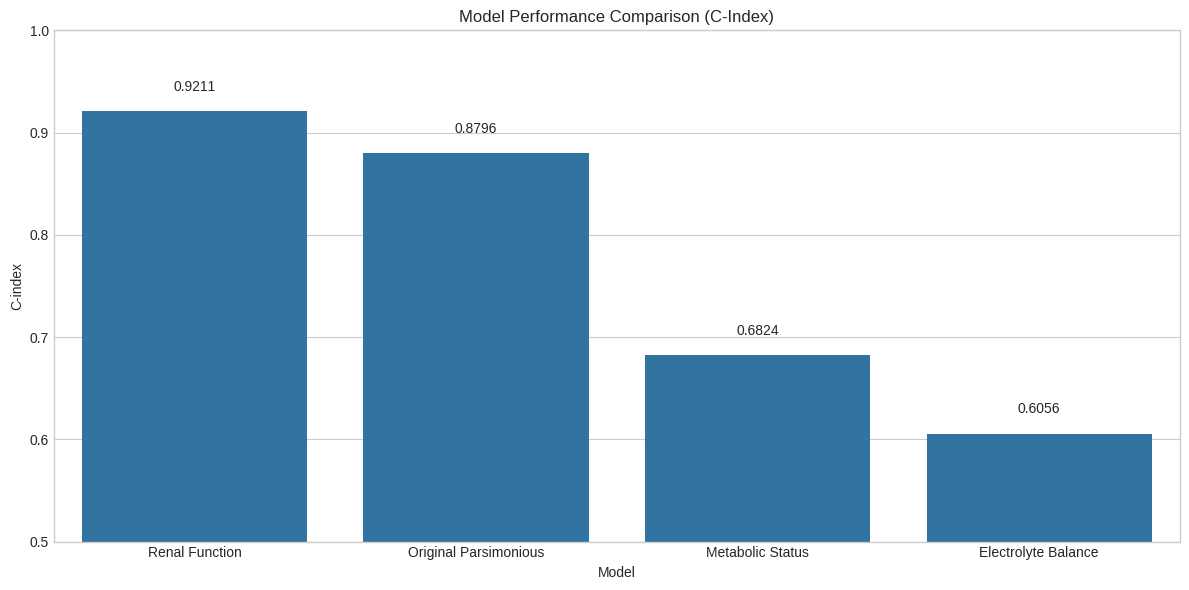

In [184]:
# Define multiple focused models based on physiological domains
print("\nImplementing multiple focused Cox models...")

# 1. Renal function model (primary kidney markers)
renal_function_vars = ['creatinine_change_scaled']
if 'urea_change_scaled' in cox_df.columns:
    renal_function_vars.append('urea_change_scaled')

# 2. Electrolyte model (fluid & electrolyte balance)
electrolyte_vars = ['potassium_change_scaled']
if 'sodium_change_scaled' in cox_df.columns:
    electrolyte_vars.append('sodium_change_scaled')
if 'cloride_change_scaled' in cox_df.columns:
    electrolyte_vars.append('cloride_change_scaled')

# 3. Metabolic model (systemic markers)
metabolic_vars = []
if 'total_choles_scaled' in cox_df.columns:
    metabolic_vars.append('total_choles_scaled')
if 'vitamin_d_scaled' in cox_df.columns:
    metabolic_vars.append('vitamin_d_scaled')

# Create and evaluate each focused model
model_results = []

# Only fit models with at least one variable
if len(renal_function_vars) > 0:
    # Renal function model
    renal_model = CoxPHFitter(penalizer=0.1)
    renal_model.fit(cox_df, duration_col='stop_time', event_col='event',
                  formula=" + ".join(renal_function_vars), strata=['age_group'],
                  robust=True, show_progress=True)
    renal_pred = renal_model.predict_partial_hazard(cox_df)
    renal_cindex = concordance_index(cox_df['stop_time'], -renal_pred, cox_df['event'])
    model_results.append({
        'Model': 'Renal Function',
        'Variables': renal_function_vars,
        'C-index': renal_cindex,
        'AIC': renal_model.AIC_partial_,
        'Log-likelihood': renal_model.log_likelihood_
    })
    print(f"\nRenal Function Model Results (C-index: {renal_cindex:.4f}):")
    print(renal_model.summary)

if len(electrolyte_vars) > 0:
    # Electrolyte model
    electrolyte_model = CoxPHFitter(penalizer=0.1)
    electrolyte_model.fit(cox_df, duration_col='stop_time', event_col='event',
                        formula=" + ".join(electrolyte_vars), strata=['age_group'],
                        robust=True, show_progress=True)
    electrolyte_pred = electrolyte_model.predict_partial_hazard(cox_df)
    electrolyte_cindex = concordance_index(cox_df['stop_time'], -electrolyte_pred, cox_df['event'])
    model_results.append({
        'Model': 'Electrolyte Balance',
        'Variables': electrolyte_vars,
        'C-index': electrolyte_cindex,
        'AIC': electrolyte_model.AIC_partial_,
        'Log-likelihood': electrolyte_model.log_likelihood_
    })
    print(f"\nElectrolyte Model Results (C-index: {electrolyte_cindex:.4f}):")
    print(electrolyte_model.summary)

if len(metabolic_vars) > 0:
    # Metabolic model
    metabolic_model = CoxPHFitter(penalizer=0.1)
    metabolic_model.fit(cox_df, duration_col='stop_time', event_col='event',
                      formula=" + ".join(metabolic_vars), strata=['age_group'],
                      robust=True, show_progress=True)
    metabolic_pred = metabolic_model.predict_partial_hazard(cox_df)
    metabolic_cindex = concordance_index(cox_df['stop_time'], -metabolic_pred, cox_df['event'])
    model_results.append({
        'Model': 'Metabolic Status',
        'Variables': metabolic_vars,
        'C-index': metabolic_cindex,
        'AIC': metabolic_model.AIC_partial_,
        'Log-likelihood': metabolic_model.log_likelihood_
    })
    print(f"\nMetabolic Model Results (C-index: {metabolic_cindex:.4f}):")
    print(metabolic_model.summary)

# Create comparison table
if len(model_results) > 0:
    # Add your original parsimonious model to the results
    model_results.append({
        'Model': 'Original Parsimonious',
        'Variables': parsimonious_vars,
        'C-index': c_index,  # From your existing model
        'AIC': cph_parsimonious.AIC_partial_,
        'Log-likelihood': cph_parsimonious.log_likelihood_
    })

    # Display comparative results
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('C-index', ascending=False)
    print("\nModel Comparison Results:")
    print(results_df)

    # Create visualization of model comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='C-index', data=results_df)
    plt.title('Model Performance Comparison (C-Index)')
    plt.ylim(0.5, 1.0)  # Adjusted range for C-index
    for i, v in enumerate(results_df['C-index']):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.tight_layout()
    plt.show()